In [1]:
import datasets
from sentence_transformers import SentenceTransformer, CrossEncoder
from functools import partial
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
    
from questeval.questeval_metric import QuestEval
from questeval.utils import LinearizeWebnlgInput
import spacy

/home/teven/virtualenvs/dev_transformers/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
/home/teven/virtualenvs/dev_transformers/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data_2017 = datasets.load_dataset("json", data_files="2017_scores.jsonl")["train"]

Using custom data configuration default-4290ac4c51bf46dd


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/teven/.cache/huggingface/datasets/json/default-4290ac4c51bf46dd/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
data_2017

Dataset({
    features: ['all_bs160_allneg', 'all_bs192_hardneg', 'bi_all-mpnet-base-v2_correctness', 'bi_all_bs160_allneg_correctness', 'bi_all_bs192_hardneg_correctness', 'bi_all_bs320_vanilla_correctness', 'bleu', 'category', 'cross_all-mpnet-base-v2_correctness', 'cross_all_bs160_allneg_correctness', 'cross_all_bs192_hardneg_correctness', 'cross_all_bs320_vanilla_correctness', 'fluency', 'grammar', 'id', 'meteor', 'mr', 'mr_processed', 'questeval_data2text', 'questeval_vanilla', 'semantics', 'systemtype', 'team', 'ter', 'text', 'triplesize', 'type', 'bi_all-mpnet-base-v2_data_coverage', 'bi_all-mpnet-base-v2_relevance', 'bi_all_bs160_allneg_data_coverage', 'bi_all_bs160_allneg_relevance', 'bi_all_bs320_vanilla_data_coverage', 'bi_all_bs320_vanilla_relevance', 'bi_all_bs192_hardneg_data_coverage', 'bi_all_bs192_hardneg_relevance', 'cross_all-mpnet-base-v2_data_coverage', 'cross_all-mpnet-base-v2_relevance', 'cross_all_bs160_allneg_data_coverage', 'cross_all_bs160_allneg_relevance', 

In [4]:
data_2017[0]

{'all_bs160_allneg': 0.5708751678,
 'all_bs192_hardneg': 0.5123692751,
 'bi_all-mpnet-base-v2_correctness': 0.4552080333,
 'bi_all_bs160_allneg_correctness': 0.4166282415,
 'bi_all_bs192_hardneg_correctness': 0.3819143772,
 'bi_all_bs320_vanilla_correctness': 0.6192097664,
 'bleu': 0.041,
 'category': 'CelestialBody',
 'cross_all-mpnet-base-v2_correctness': 0.4815328717,
 'cross_all_bs160_allneg_correctness': 0.5046746135,
 'cross_all_bs192_hardneg_correctness': 0.502710402,
 'cross_all_bs320_vanilla_correctness': 0.4995856285,
 'fluency': 1.6666666667,
 'grammar': 1.6666666667,
 'id': 1,
 'meteor': 0.1859555125,
 'mr': '(29075)_1950_DA | discoverer | Carl_A._Wirtanen',
 'mr_processed': '[S] (29075)_1950_DA [P] discoverer [O] Carl_A._Wirtanen ',
 'questeval_data2text': 0.111144729,
 'questeval_vanilla': 0.2128931259,
 'semantics': 1.3333333333,
 'systemtype': 'neural',
 'team': 'adapt',
 'ter': -90.909,
 'text': 'the 29075 club is the dictcoverer, carl a. wirtsen.',
 'triplesize': '1tr

In [5]:
# ticks = ["semantic_adequacy", "grammaticality", "fluency", "similarity_allneg", "similarity_replaceneg", "bleu", "meteor", "ter"]
# ticks = ["semantics", "grammar", "fluency", "bleu", "meteor", "ter", "questeval_vanilla", "questeval_data2text"]
ticks = ["semantics", "grammar", "fluency", "bleu", "meteor", "ter", "questeval_vanilla", "questeval_data2text"]
base_models = ["all_bs160_allneg", "all_bs192_hardneg", "all_bs320_vanilla", "all-mpnet-base-v2"]
types = ["bi", "cross"]
metrics = ["correctness", "data_coverage", "relevance", "metric_average"]

In [6]:
data_2017 = data_2017.filter(lambda x: x["team"] != "webnlg")
print(len(data_2017))
averaged_data = data_2017.map(lambda examples: {k: [np.mean(examples[k])] for k in ticks}, batched=True, batch_size=len(set(data_2017["team"])),
                          remove_columns=[k for k in data_2017.column_names if k not in ticks])

  0%|          | 0/3 [00:00<?, ?ba/s]

2007


  0%|          | 0/223 [00:00<?, ?ba/s]

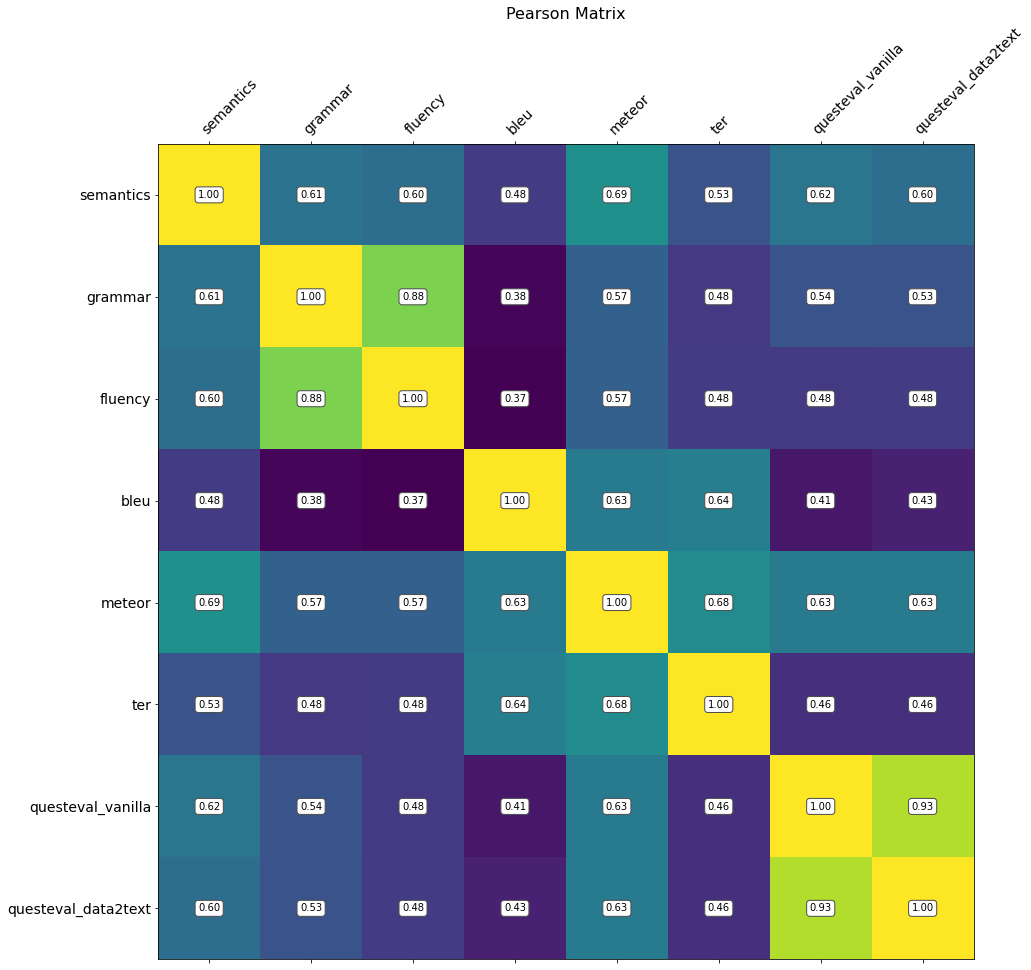

In [7]:
correlations = np.corrcoef(np.stack([data_2017[tick] for tick in ticks]))
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations)
for (i, j), z in np.ndenumerate(correlations):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, ha='left', rotation_mode='anchor')
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Pearson Matrix', fontsize=16);

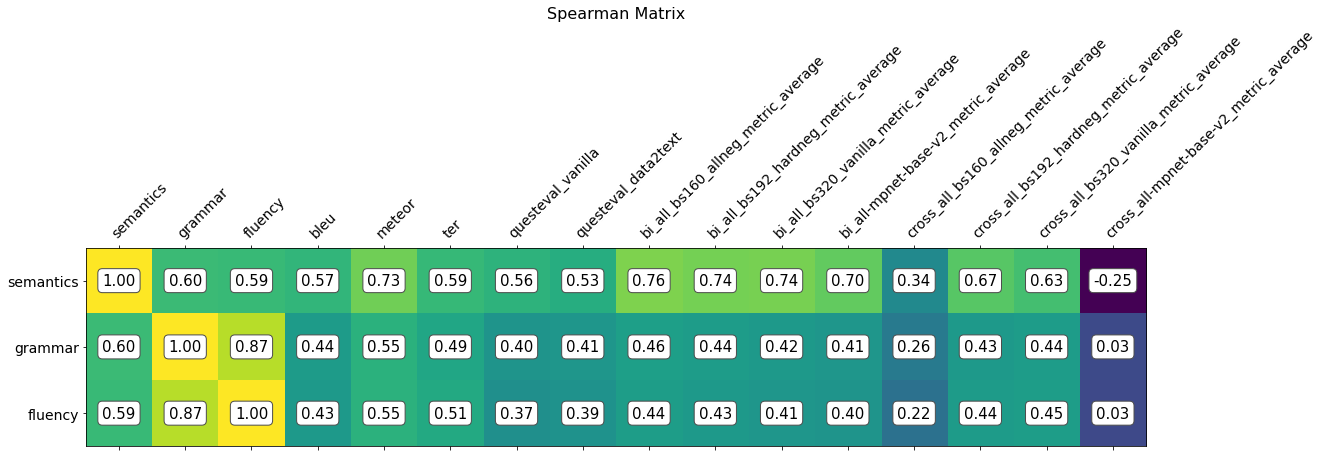

In [15]:
ticks = ["semantics", "grammar", "fluency"]
ticks.extend(["bleu", "meteor", "ter", "questeval_vanilla", "questeval_data2text"])
ticks.extend([f"{type}_{name}_{metric}" for metric in ["metric_average"] for type in types for name in base_models])
correlations = spearmanr(np.stack([data_2017[tick] for tick in ticks]), axis=1)[0]

f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations[:3, :])
for (i, j), z in np.ndenumerate(correlations):
    if i > 2:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=15,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, rotation_mode="anchor", ha="left")
plt.yticks(range(3), ticks[:3], fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Spearman Matrix', fontsize=16);

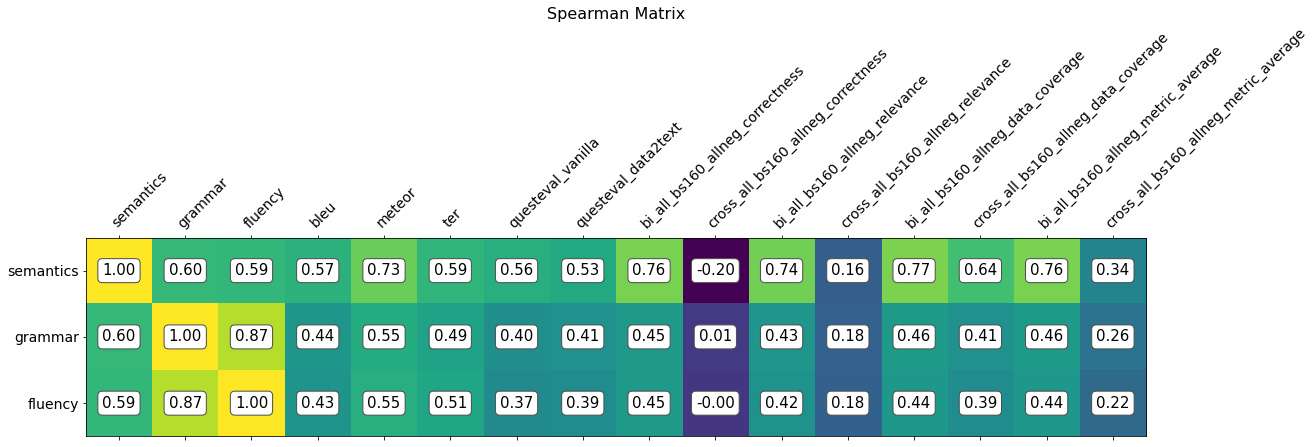

In [16]:
ticks = ["semantics", "grammar", "fluency"]
ticks.extend(["bleu", "meteor", "ter", "questeval_vanilla", "questeval_data2text"])
ticks.extend([f"{type}_{name}_{metric}" for metric in ["correctness", "relevance", "data_coverage", "metric_average"] for type in types for name in ["all_bs160_allneg"]])
correlations = spearmanr(np.stack([data_2017[tick] for tick in ticks]), axis=1)[0]

f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations[:3, :])
for (i, j), z in np.ndenumerate(correlations):
    if i > 2:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=15,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, rotation_mode="anchor", ha="left")
plt.yticks(range(3), ticks[:3], fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Spearman Matrix', fontsize=16);

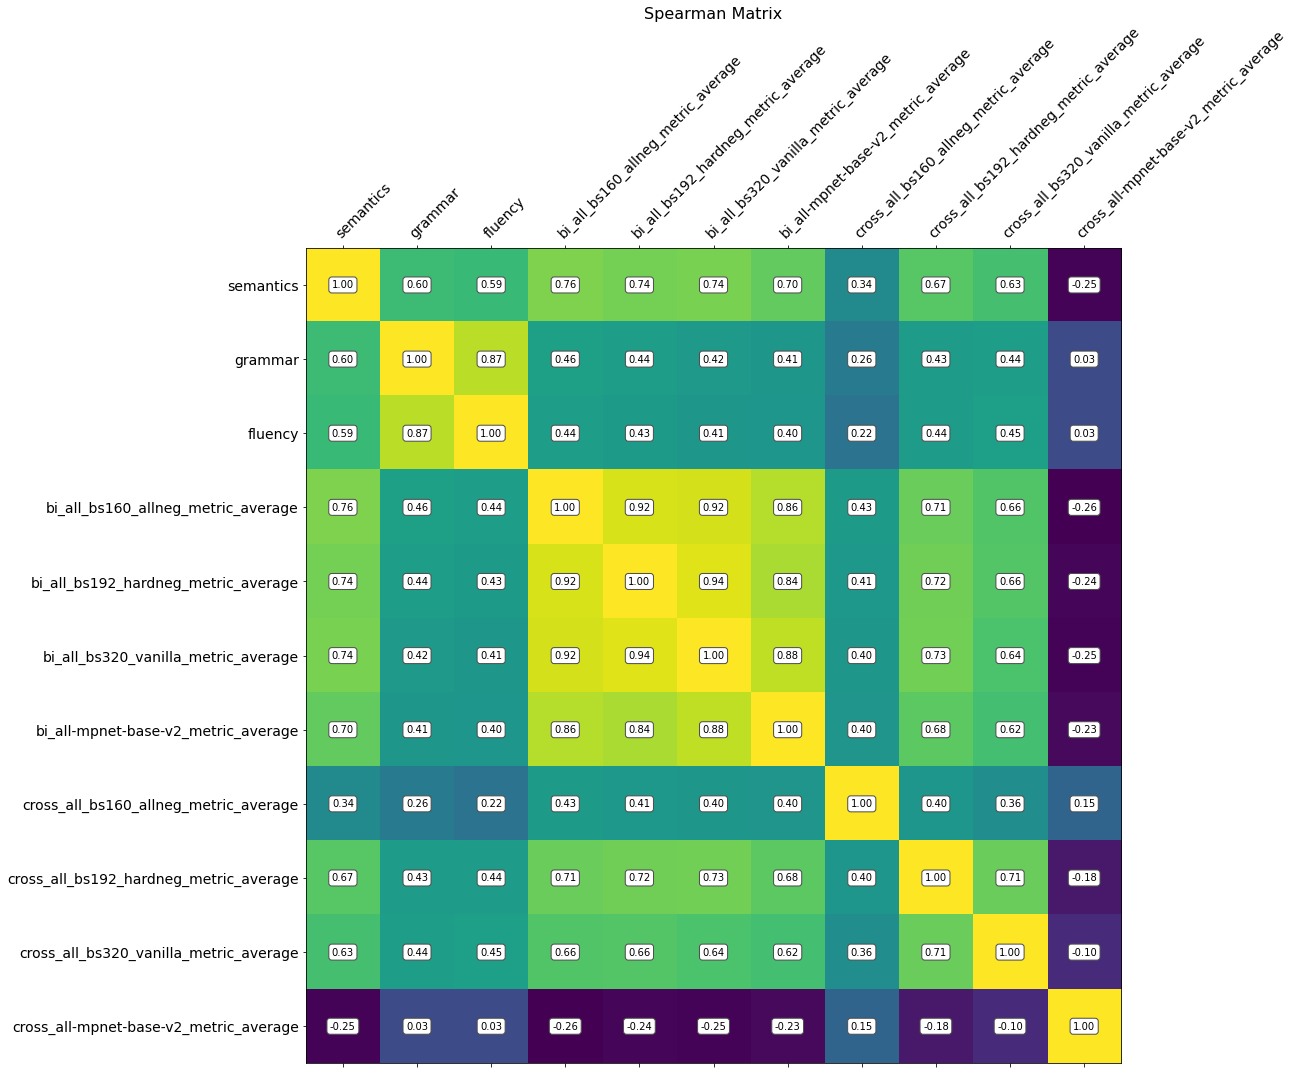

In [10]:
spearmans = spearmanr(np.stack([data_2017[tick] for tick in ticks]), axis=1)[0]
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(spearmans)
for (i, j), z in np.ndenumerate(spearmans):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, ha='left', rotation_mode='anchor')
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Spearman Matrix', fontsize=16);

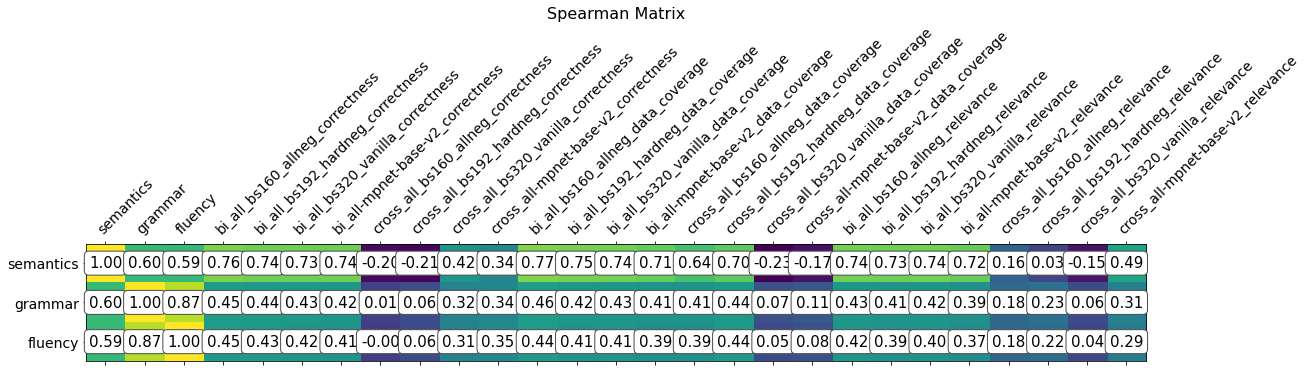

In [18]:
ticks = ["semantics", "grammar", "fluency"]
ticks.extend([f"{type}_{name}_{metric}" for metric in metrics for type in types for name in base_models])
correlations = spearmanr(np.stack([data_2017[tick] for tick in ticks]), axis=1)[0]

f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations[:3, :])
for (i, j), z in np.ndenumerate(correlations):
    if i > 2:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=15,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, rotation_mode="anchor", ha="left")
plt.yticks(range(3), ticks[:3], fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Spearman Matrix', fontsize=16);

In [16]:
print(ticks)

['semantics', 'grammar', 'fluency', 'bi_all_bs160_allneg_correctness', 'bi_all_bs160_allneg_data_coverage', 'bi_all_bs160_allneg_relevance', 'bi_all_bs192_hardneg_correctness', 'bi_all_bs192_hardneg_data_coverage', 'bi_all_bs192_hardneg_relevance', 'bi_all_bs320_vanilla_correctness', 'bi_all_bs320_vanilla_data_coverage', 'bi_all_bs320_vanilla_relevance', 'bi_all-mpnet-base-v2_correctness', 'bi_all-mpnet-base-v2_data_coverage', 'bi_all-mpnet-base-v2_relevance', 'cross_all_bs160_allneg_correctness', 'cross_all_bs160_allneg_data_coverage', 'cross_all_bs160_allneg_relevance', 'cross_all_bs192_hardneg_correctness', 'cross_all_bs192_hardneg_data_coverage', 'cross_all_bs192_hardneg_relevance', 'cross_all_bs320_vanilla_correctness', 'cross_all_bs320_vanilla_data_coverage', 'cross_all_bs320_vanilla_relevance', 'cross_all-mpnet-base-v2_correctness', 'cross_all-mpnet-base-v2_data_coverage', 'cross_all-mpnet-base-v2_relevance']


LinregressResult(slope=1.7672487810938353, intercept=0.7885228426607738, rvalue=0.7251253013948553, pvalue=0.0, stderr=0.03748048040356004, intercept_stderr=0.030888753476974874)


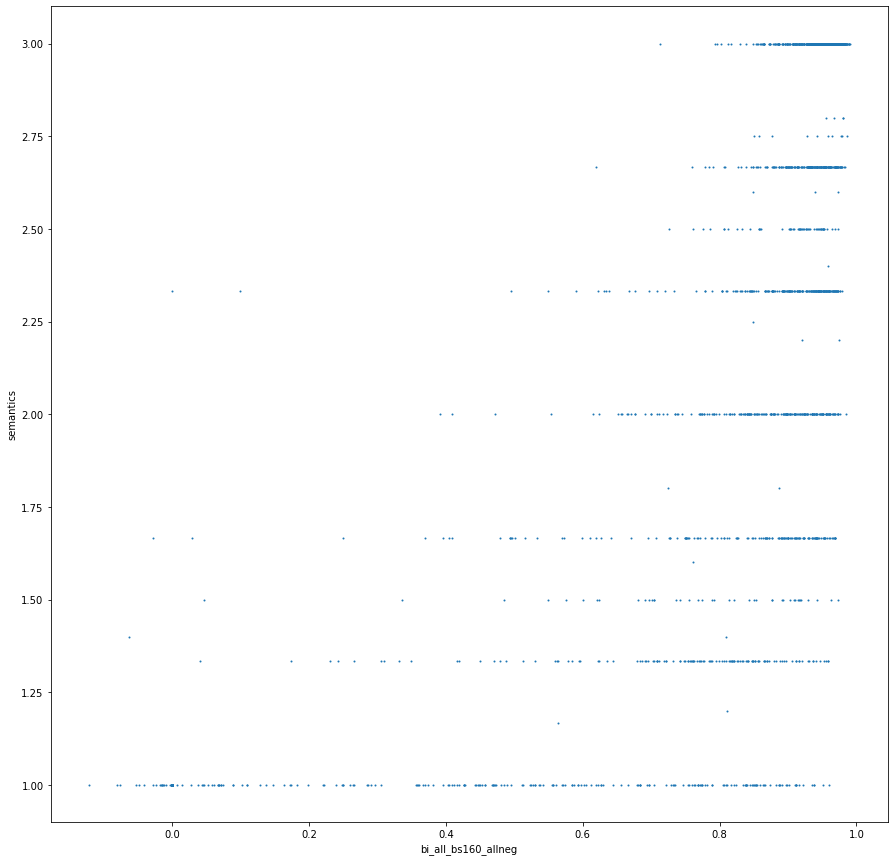

In [11]:
f = plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.scatter(data_2017["bi_all_bs160_allneg"], data_2017["semantics"], s=1)
ax.set_xlabel("bi_all_bs160_allneg")
ax.set_ylabel("semantics")

from scipy.stats import linregress

print(linregress(data_2017["bi_all_bs160_allneg"], data_2017["semantics"])) #x and y are arrays or l

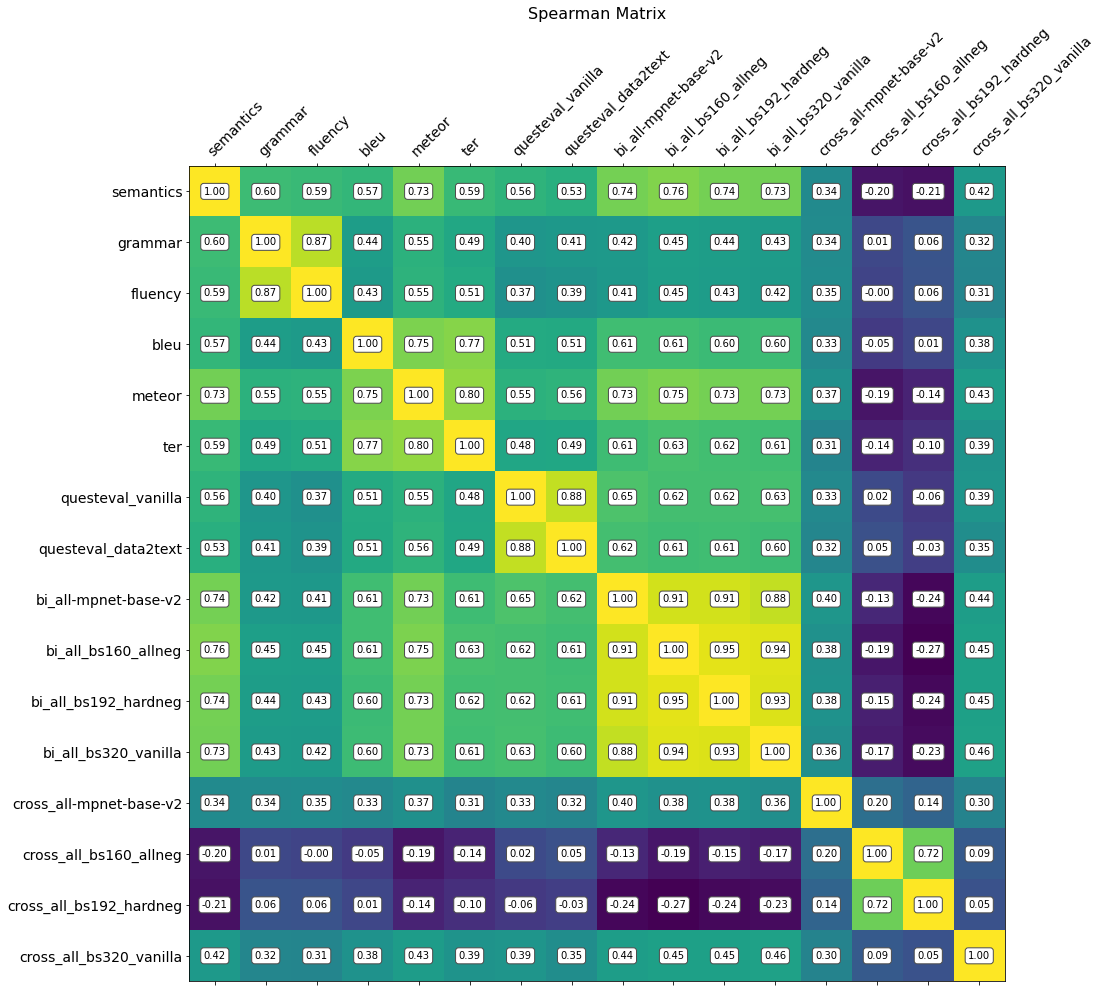

In [11]:
spearmans = spearmanr(np.stack([data_2017[tick] for tick in ticks]), axis=1)[0]
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(spearmans)
for (i, j), z in np.ndenumerate(spearmans):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, ha='left', rotation_mode='anchor')
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Spearman Matrix', fontsize=16);